<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ-и-подготовка-признаков" data-toc-modified-id="Анализ-и-подготовка-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и подготовка признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LinearSVR" data-toc-modified-id="LinearSVR-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>LinearSVR</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-3.2.6"><span class="toc-item-num">3.2.6&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Результаты-работы-обученных-моделей-на-тренировочной-выборке" data-toc-modified-id="Результаты-работы-обученных-моделей-на-тренировочной-выборке-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Результаты работы обученных моделей на тренировочной выборке</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. 
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders`.

## Подготовка

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import LinearSVR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [172]:
taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]).sort_index()

In [173]:
taxi.tail(5)

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [174]:
print('Размер исходного датасета - ', taxi.shape)
print('Количество пропусков - ', taxi.isna().sum())

Размер исходного датасета -  (26496, 1)
Количество пропусков -  num_orders    0
dtype: int64


In [175]:
def oneplot(df=taxi, title1='', height=5, width=15):
    
    fig, ax = plt.subplots()
    
    plt.rcParams['font.size'] = '14'
    
    ax.minorticks_on()
    
    line = sns.lineplot(data=df, palette='mako',linewidth=3, dashes=False)
    
    line.set_title(title1, fontdict={'fontsize': 16})

    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    ax.grid(which='minor',color = 'lightblue', linewidth = 1, linestyle=':')
    
    fig.set_figheight(height)
    fig.set_figwidth(width)
    
    return line

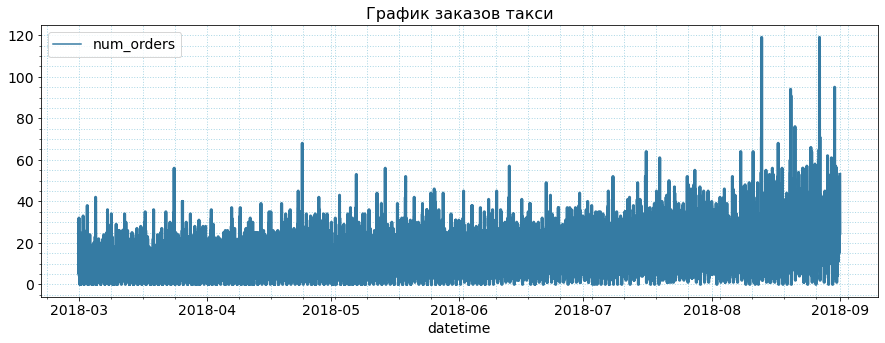

In [176]:
oneplot(title1='График заказов такси')
plt.show()

Объединим данные за час.

In [177]:
taxi = taxi.resample('1H').sum()

In [178]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [179]:
taxi.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


In [180]:
print('Ряд монотонно возрастающий') if taxi.index.is_monotonic else print('ряд не монотонный')   
print('Дата начала - ', taxi.index.min())
print('Дата окончания - ', taxi.index.max())

Ряд монотонно возрастающий
Дата начала -  2018-03-01 00:00:00
Дата окончания -  2018-08-31 23:00:00


Данные представлены с марта по август 2018 г.

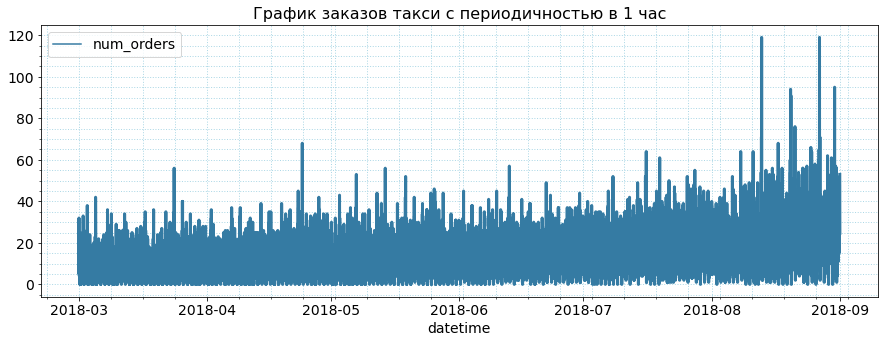

In [181]:
oneplot(title1='График заказов такси с периодичностью в 1 час')
plt.show()

**Вывод**
***

Представленные данные - это временной ряд размером (26496, 1) с индексом в формате дата-время.  

Данные ресеплированы с периодичностью в 1 час по сумме заказов в час.   
Ряд монотонно-возрастающий, данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.
После ресемплирования показатели данных составили:
- cреднее количество заказов - 84, 
- медиана - 78, 
- стандартного отклонение - 45.  
- минимальное количетво заказов в час - 0, максимальное - 462.

Необходимо построить модель, которая будет предсказывать количество заказов - следовательно решается задача регрессии временного ряда.  
Для посмтроения модели необходимо проверить ряд на стационарность, проверить распределение данных и сгенерировать признаки для обучения модели.

## Анализ и подготовка признаков

Рассмотрим распределение целевого признака num_orders

In [182]:
def barplot_sns(df, X, Y, title1='', xlabel1='', ylabel1='', rotation_x=0, figsize_1=(15, 5)):    
    
    fig, ax = plt.subplots(figsize=figsize_1)
    
    bar = sns.barplot(data=df, x=X, y=Y, palette='mako')
    
    bar.set_title(title1, fontdict={'fontsize': 14})
    
    bar.set_xlabel(xlabel1, fontsize=14)
    bar.set_ylabel(ylabel1, fontsize=14)
    
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    plt.xticks(rotation=rotation_x)
    
    return bar

In [183]:
# тепловая карта корреляции

def heatmap_b(df, title_1='Корреляция признаков'):
    plt.figure(figsize=(15, 8))

    matrix = np.triu(df.corr())
    
    heatmap_b = sns.heatmap((df.corr()), 
        vmin=-1, 
        vmax=1, 
        cmap="YlGnBu", 
        annot=True, 
        fmt='.2g', mask=matrix, annot_kws={'fontsize':5})


    heatmap_b.set_title(title_1, fontdict={'fontsize':16})

    return heatmap_b

In [184]:
def kdeplot(data, xlabel1='',
                 figsize_1=(15, 5), label1='', suptitle1='', ylabel1='', lg=''):
    
    fig, ax = plt.subplots(figsize=figsize_1)

    fig.suptitle(suptitle1, fontsize=16)

    kdeplot_t = sns.kdeplot(data, color='mediumblue', 
                            alpha=.4, shade=True, label=label1) 

    kdeplot_t.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    kdeplot_t.set_xlabel(xlabel1, fontsize=14)
    kdeplot_t.set_ylabel(ylabel1, fontsize=14)
    
    kdeplot_t.legend([lg], fontsize=12)
        
    return kdeplot_t

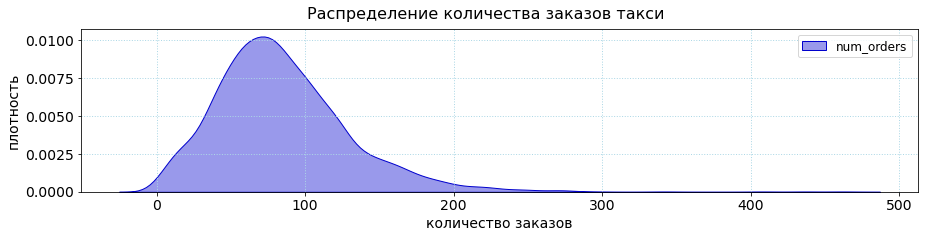

In [185]:
kdeplot(taxi['num_orders'], suptitle1='Распределение количества заказов такси',
       xlabel1='количество заказов', figsize_1=(15, 3), ylabel1='плотность', lg='num_orders')
plt.show()

In [186]:
print('Медианное значение заказов такси/час', taxi['num_orders'].median())

Медианное значение заказов такси/час 78.0


Распределение количества заказов нормальное, пик приходится на 78 заказов в час. Максимальное количество заказов доходит до 462, но, в целом, более 200 заказов в час - это редкость. 

С помощью теста Дики-Фуллера проверим ряд на стационарность.

Проверим гипотезу о том, что наш ряд является стационарным.

Нулевая гипотеза Н0 - ряд не стационарен, заказы появляются в случайном порядке.  
Альтернативная гипотеза Н1 - ряд не имеет единичного корня и ряд стационарен.  

Примем уровень статистической значимости равный 5%.

In [187]:
adf = adfuller(taxi)

print('adf', adf[0])
print('p-value: ', adf[1])
print('critical values', adf[4])

if adf[0] > adf[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf -3.068924289027936
p-value:  0.028940051402614502
critical values {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Ряд стационарен, следовательно у нас есть временной период, в котором колчиество заказов такси остается неизменным.  

Вычислим стандартное среднее и скользящее стандартное отклонение, с размером окна 50.

In [188]:
taxi['mean'] = taxi['num_orders'].rolling(50).mean()
taxi['std'] = taxi['num_orders'].rolling(50).std()
taxi.head()

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


Построим график и рассмотрим как меняется скользящее среднее и стандартное отклонение на протяжении всего времени.

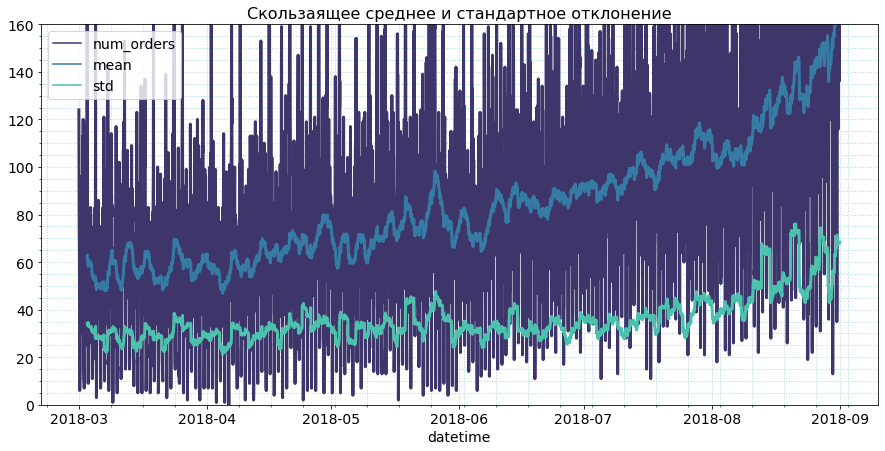

In [189]:
oneplot(df=taxi, height=7, title1='Скользаящее среднее и стандартное отклонение')
plt.ylim(0, 160)
plt.show()

Судя по графику, среднее и стандартное отклонение со временем меняется - на 03.2018 ~ 60, на 08.2018 ~ 140 заказов в час.

Выполним декомпозицию ряда, разложим на сезонность, тренды и шум.  
Далее построим графики каждого атрибута.

In [190]:
decomposed = seasonal_decompose(taxi[['num_orders']])

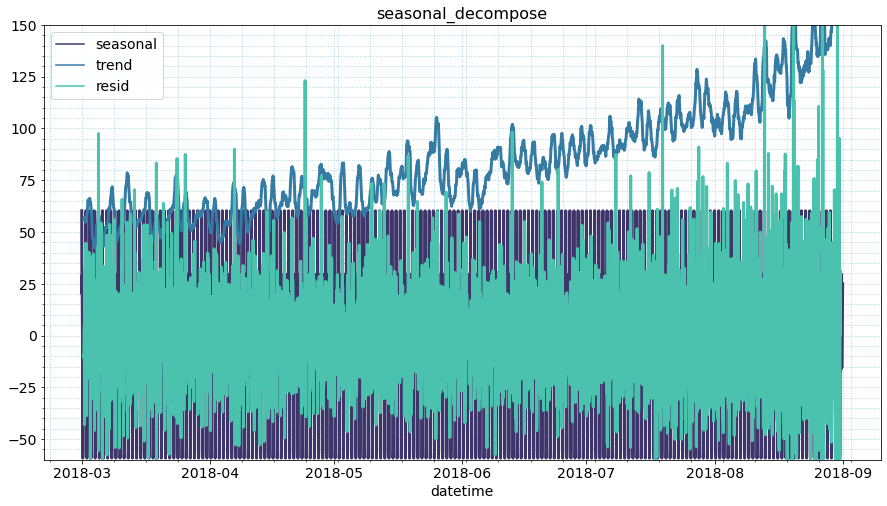

In [191]:
oneplot(df=[decomposed.seasonal, decomposed.trend, decomposed.resid] , height=8, title1='seasonal_decompose')
plt.ylim(-60, 150)
plt.show()

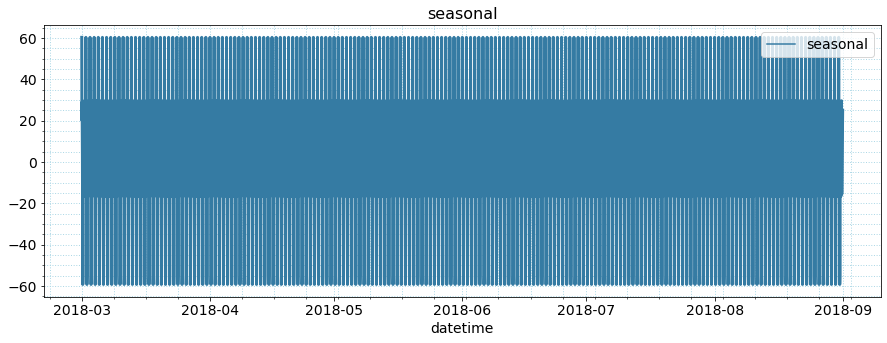

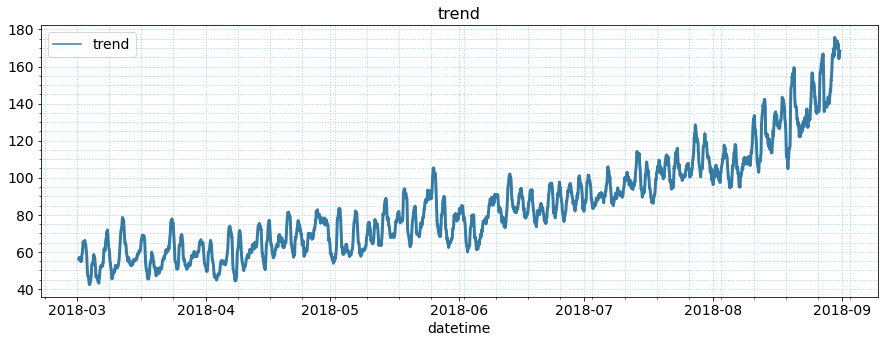

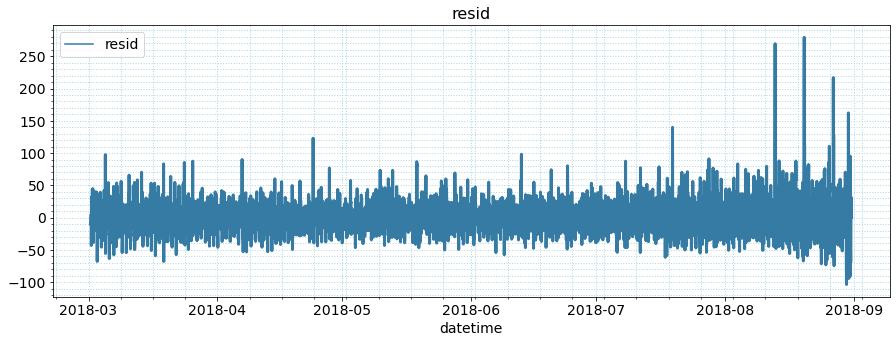

In [192]:
oneplot(df=[decomposed.seasonal] , height=5, title1='seasonal')
oneplot(df=[decomposed.trend] , height=5, title1='trend')
oneplot(df=[decomposed.resid] , height=5, title1='resid')
plt.show()

На графике виден восходящий тренд - с течением времени количество заказов увеличивается.   
Так же, наблюдается сезонность в данных, выделим ее отдельно и проверим ее период.

Укрупним график сезонности по месяцам.

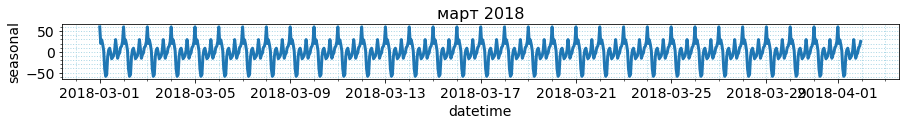

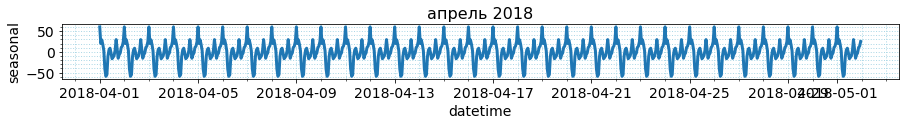

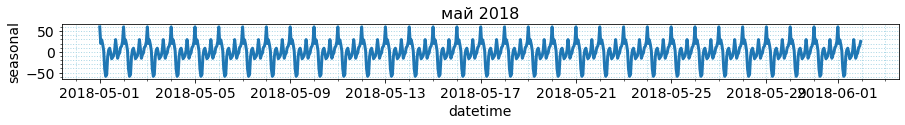

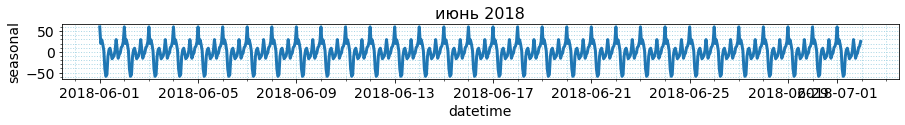

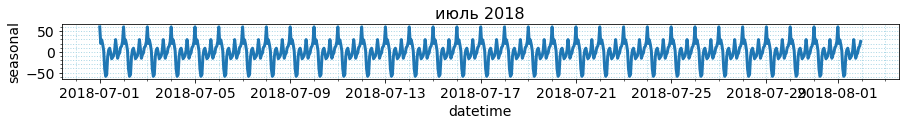

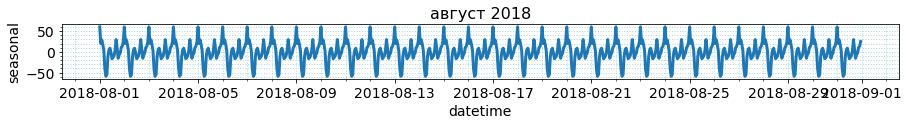

In [193]:
month_list = ['март', 'апрель', 'май', 'июнь', 'июль', 'август']

for i in range(3, 9):

    oneplot(df=decomposed.seasonal['2018-0' + str(i) + '-01' : '2018-0' + str(i + 1) + '-01'], 
            height=1, width=15, title1=(month_list[i-3] + ' ' + str(2018)))

В разерезе месяца хорошо видна сезонность заказов в 1 сутки. 

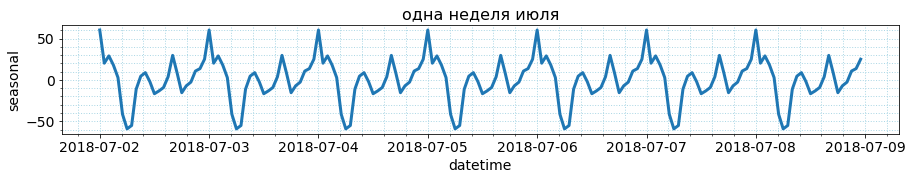

In [194]:
oneplot(df=decomposed.seasonal['2018-07-02':'2018-07-08'], height=2, title1='одна неделя июля')
plt.show()

Наблюдается сезонность с периодичностью в одни сутки, максимальное количество заказов вечером и ближе к 12 ночи, среднее в течение дня и самое минимальное количество заказов утром. Рассмотрим подробнее, сгруппировав по часам.

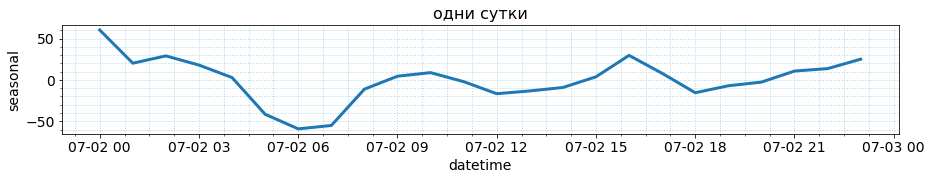

In [195]:
oneplot(df=decomposed.seasonal['2018-07-02':'2018-07-02'], height=2, title1='одни сутки')
plt.show()

Создадим новые признаки для обучеиня модели: 

- день ['day']
- день недели ['dayofweek']
- час ['hour']
- сезонность ['seasonal']

а так же, смещенный ряд со скользящим средним ['rolling_mean'] с шириной окна rolling_mean_size и смещенные ряды ['lag_n'].

In [196]:
def make_features(data, max_lag, rolling_mean_size):

    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['seasonal'] = np.around(decomposed.seasonal)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
  
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

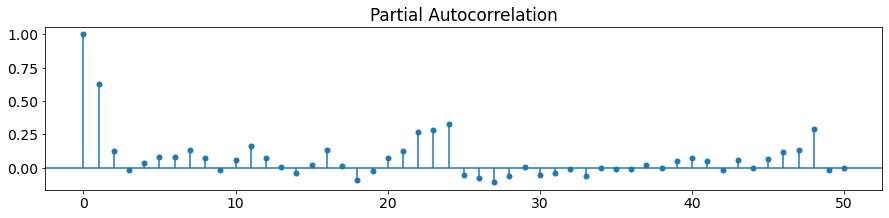

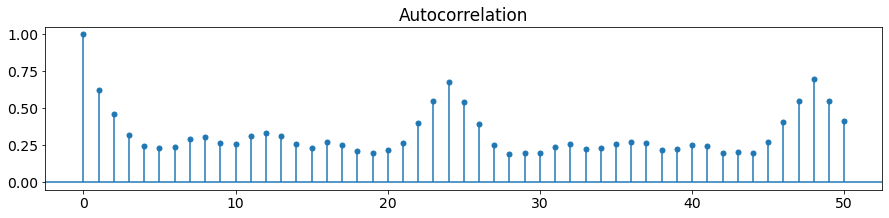

In [197]:
plot_pacf(taxi['num_orders'].values.squeeze(), lags=50, alpha=None).set_size_inches(15, 3)
plt.show()

plot_acf(taxi['num_orders'].values.squeeze(), lags=50, alpha=None).set_size_inches(15, 3)
plt.show()

In [198]:
make_features(taxi, 24, 25)
taxi.head()

,num_orders,mean,std,dayofweek,day,hour,seasonal,lag_1,lag_2,lag_3,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,1,20.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,1,2,29.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,18.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,1,4,3.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.000000,54.000000,78.000000,107.000000,462.000000
mean,4367.0,84.099418,25.148001,46.860000,64.040000,79.400000,99.880000,171.060000
std,4367.0,35.793947,9.572712,21.166984,30.050495,33.032087,38.659492,76.143999
dayofweek,4416.0,3.005435,1.990684,0.000000,1.000000,3.000000,5.000000,6.000000
day,4416.0,15.836957,8.855229,1.000000,8.000000,16.000000,23.250000,31.000000
hour,4416.0,11.500000,6.922970,0.000000,5.750000,11.500000,17.250000,23.000000
seasonal,4416.0,0.041667,26.176231,-59.000000,-11.500000,3.500000,15.000000,60.000000
lag_1,4415.0,84.395470,44.992356,0.000000,54.000000,78.000000,107.000000,462.000000
lag_2,4414.0,84.364069,44.949043,0.000000,54.000000,78.000000,107.000000,462.000000
lag_3,4413.0,84.347156,44.940088,0.000000,54.000000,78.000000,107.000000,462.000000


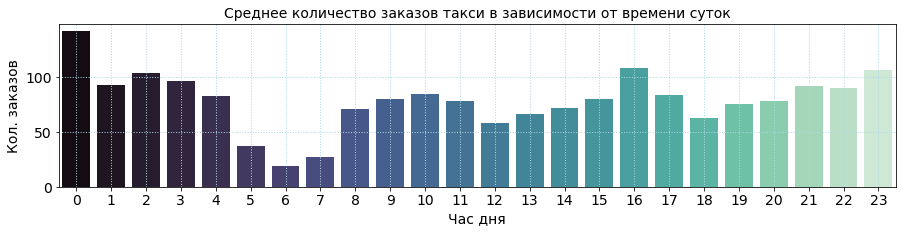

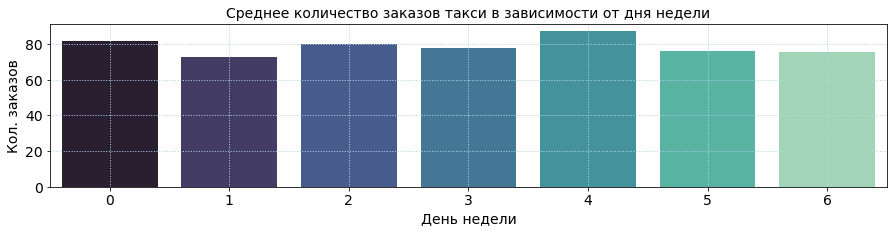

In [200]:
barplot_sns((taxi[['num_orders', 'hour']].groupby(by='hour').agg('median').reset_index()), 
            X='hour', Y='num_orders', xlabel1='Час дня', ylabel1='Кол. заказов', 
            title1='Среднее количество заказов такси в зависимости от времени суток', figsize_1=(15, 3))


barplot_sns((taxi[['num_orders', 'dayofweek']].groupby(by='dayofweek').agg('median').reset_index()), 
            X='dayofweek', Y='num_orders', xlabel1='День недели', ylabel1='Кол. заказов', 
            title1='Среднее количество заказов такси в зависимости от дня недели', figsize_1=(15, 3))
plt.show()

Максимальное количество заказов в полночь - в среднем до 140 заказов, уменьшается на примерно 30% ближе к часу ночи и оставется примерно на таком уровне до 4 утра включительно, к 5 утра спрос резко падает и повышается только к 8 утра.   
Среди дня самый высокий спрос в 16:00, в среднем, выше 60 заказов наблюдается в периоды с 8 утра до 12 дня и с 13:00 до 04:00.    

В среднем, по пятницам больше всего заказов такси - около 90 в сутки, чуть ниже количество заказов по понедельникам и средам - около 80 заказов в сутки в среднем за весь представленный период. В остальные дни заказов в среднем чуть ниже 80 в сутки.

Проверим корреялцию новых признаков. 

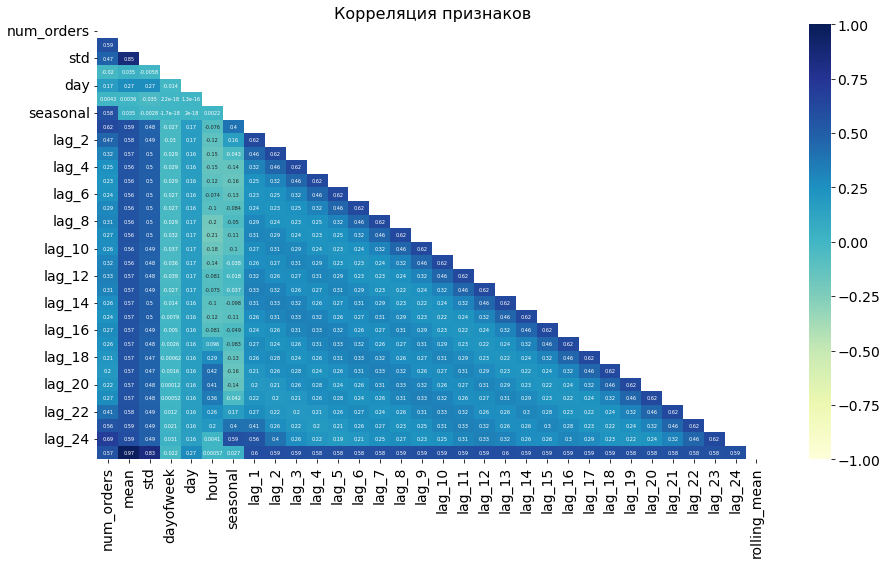

In [201]:
heatmap_b(taxi)
plt.show()

In [202]:
taxi = taxi.drop(['mean', 'std'], axis=1)

**Вывод**
***  
С помощью теста Дики-Фуллера ряд был проверен на стационарность - ряд стационарен.  
Во временном ряду наблюдается восходящий тренд - с течением времени количество заказов увеличивается.  
Наблюдается сезонность количества заказов с периодичностью в сутки.  
Наибольшее количество заказов такси в полночь, наименьшее - рано утром (6 утра).  
В среднем, наибольшее количество заказов такси по пятницам.  

В целях обучения модели сгенерированы новые признаки: 
- день ['day']
- день недели ['dayofweek']
- час ['hour']
- скользящее среднее ['rolling_mean'] с шириной окна 50 и 24 смещенных рядов ['lag_n'].


## Обучение

Подготовим выборки для обучения моделей. 

Обучим с помощью кросс-валидации для временных рядов модели: 
- LinearRegression  
- LGBMRegressor  
- RandomForestRegressor
- LinearSVR  
- Lasso  
- ElasticNet  

Для оценки точности предсказания будем использовать метрику RMSE.

### Подготовка выборок

In [203]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

In [204]:
print('Размер тренировочной выборки признаков:', train.shape)
print('Размер тестовой выборки признаков:', test.shape)

Размер тренировочной выборки признаков: (3949, 30)
Размер тестовой выборки признаков: (442, 30)


In [205]:
print('Минимум тренировочной выборки:', train.index.min(), 
          'Максимум тренировочной выборки::', train.index.max(), sep='\n')

print('Минимум тестовой выборки:', test.index.min(), 
          'Максимум тестовой выборки:', test.index.max(), sep='\n')

Минимум тренировочной выборки:
2018-03-02 01:00:00
Максимум тренировочной выборки::
2018-08-13 13:00:00
Минимум тестовой выборки:
2018-08-13 14:00:00
Максимум тестовой выборки:
2018-08-31 23:00:00


Конец тренировочной выборки- начало тестовой. Выборки разделены корректно.

In [206]:
train.head()

,num_orders,dayofweek,day,hour,seasonal,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,4,2,1,20.0,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,58.16
2018-03-02 02:00:00,75,4,2,2,29.0,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,58.00
2018-03-02 03:00:00,64,4,2,3,18.0,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.60
2018-03-02 04:00:00,20,4,2,4,3.0,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,57.32
2018-03-02 05:00:00,11,4,2,5,-42.0,20.0,64.0,75.0,120.0,90.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,55.48


In [207]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

In [208]:
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [209]:
# проверка размера выборок 
print('Размер тренировочной выборки признаков:', features_train.shape, 
          'целевого признака:', target_train.shape, sep='\n')
print('Размер тестовой выборки признаков:', features_test.shape, 
          'целевого признака:', target_test.shape, sep='\n')

Размер тренировочной выборки признаков:
(3949, 29)
целевого признака:
(3949,)
Размер тестовой выборки признаков:
(442, 29)
целевого признака:
(442,)


**Вывод**
***
Подготовлена тренировочная и тестовая выборки, без перемешивания, а так же, выделен целевой признак.  

### Обучение моделей

In [210]:
# график: вероятность распределения предсказани и целевого признака
# для оценки точности предсказания

def predictions_kdeplot(prediction_model, target_real,
                  suptitle_1='Вероятность распределения целевого признака - предсказанного и реального',
                 figsize_1=(15, 5), name_1="предсказание целевого признака", name_2="истиные значения целевого признака"):
    
    fig, axs = plt.subplots(figsize=figsize_1)
    
    
    fig.suptitle(suptitle_1, fontsize=16)

        
    kdeplot_t = sns.kdeplot(prediction_model, color='mediumblue', 
                        alpha=.4, shade=True, label=name_1)
        
    kdeplot_t = sns.kdeplot(target_real, color='lightgreen',
                        alpha=.4, shade=True, linewidth = 1, label=name_2)

    kdeplot_t.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    kdeplot_t.set_xlabel('Целевой признак', fontsize=16)
    kdeplot_t.set_ylabel('Плотность', fontsize=16)
    
    kdeplot_t.legend(fontsize=15)
        
    return kdeplot_t

rndm_search - Перекрестной проверкой находим лучшие гиперпараметры модели  
С учетом разделения по временным рядам  
Вовзращает - модель с лучшими гиперпараметрами и лучшую оценку 

In [211]:
def rndm_search(model, paramns, features=features_train, target=target_train, 
                scoring_m='neg_root_mean_squared_error'):
    
    tscv = TimeSeriesSplit(n_splits=10)
    print('Количество итераций: ', tscv.get_n_splits([features, target]))
    
    RSCV = RandomizedSearchCV(estimator=model, param_distributions=paramns, 
                              cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=5)

    RSCV.fit(features, target)

    best_estimator = RSCV.best_estimator_
    best_score = RSCV.best_score_
   
    print('Модель с лучшими гиперпараметрами', best_estimator)
    print(f'RMSE {(best_score * (-1)):.2f}'.format())
    
    return best_estimator, (best_score * (-1))

Списки для создания сравнительного датасета.
- model_name - наименование модели
- best_model - лучшая модель
- rmse_train - RMSE на тренировочной выборке
- pred_train -  предсказания на тренировочной выборке
- rmse_test - RMSE на тестовой выборке
- pred_test -  предсказания на тестовой выборке  

append_train_result - добавляет результаты обучения (для тренировочной выборки)

In [212]:
model_name, best_model, rmse_train, pred_train, rmse_test, pred_test = [], [], [], [], [], []

In [213]:
def append_train_result(m_name, model, rmse_train_m, train_prediction):
    
    model_name.append(m_name)
    best_model.append(model)
    rmse_train.append(rmse_train_m)
    pred_train.append(train_prediction)

Создадим датасет predict_train в которым индексом будут даты заказов, реальные целевые признаки (измененные скользящим средним). Далее добавим предсказания моделей и построим сравнительные графики.

In [214]:
predict_train = pd.DataFrame(index=features_train.index)
predict_train['real_target'] = target_train
predict_train['real_target'] = predict_train['real_target'].rolling(50).mean()

In [215]:
print('Ряд монотонно возрастающий') if predict_train.index.is_monotonic else print('ряд не монотонный')

Ряд монотонно возрастающий


Добавляет колонку предсказаний модели в датасет и заменяет предскаазния на скользящее среднее для графика, ширина окна по умолчанию 50.

In [216]:
def new_col(df, pred, name='model_name', rolling_size=50):
    
    df[name] = pred
    df[name] = df[name].rolling(rolling_size).mean()
    
    return df    

#### Линейная регрессия

In [217]:
param_lr = {'fit_intercept': [True, False], 
            'normalize': [True, False], 
            'copy_X': [True, False], 
            'n_jobs': [-1], 
            'positive': [True, False]}

Находим с помощью RandomizedSearchCV модель с лучшими гиперпараметрами, возвращаем модель и оценку RMSE.  
Выводим на экран время работы.

In [218]:
%%time
lg, rmse_lg = rndm_search(LinearRegression(), param_lr)

Количество итераций:  10
Модель с лучшими гиперпараметрами LinearRegression(fit_intercept=False, n_jobs=-1, normalize=True, positive=True)
RMSE 23.98
Wall time: 308 ms


In [219]:
pred_lg = lg.predict(features_train)

Добавляем результаты в списки

In [220]:
append_train_result('LinearRegression', lg, rmse_lg, pred_lg)

**Вывод**
***  
Модель с лучшими гиперпараметрами LinearRegression(fit_intercept=False, n_jobs=-1, normalize=True, positive=True).  
RMSE на тренировочной выборке модели линейной регрессии составила 24.

#### Градиентный бустинг

In [221]:
params_lgb = {'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 36],
    'learning_rate': [.1, .3],
    'n_estimators': [100, 130],
    'subsample_for_bin': [100000, 200000],
              'n_jobs': [-1]
             }

In [222]:
%%time
lgbm, rmse_lgbm = rndm_search(lgb.LGBMRegressor(random_state=5), params_lgb)

Количество итераций:  10
Модель с лучшими гиперпараметрами LGBMRegressor(n_estimators=130, random_state=5)
RMSE 23.49
Wall time: 5.32 s


In [223]:
pred_lgbm_train = lgbm.predict(features_train)
pred_lgbm_train

array([103.8587758 ,  67.14943939,  57.8920298 , ..., 141.24987943,
       100.46813375, 115.02587085])

In [224]:
append_train_result('LGBMRegressor', lgbm, rmse_lgbm, pred_lgbm_train)

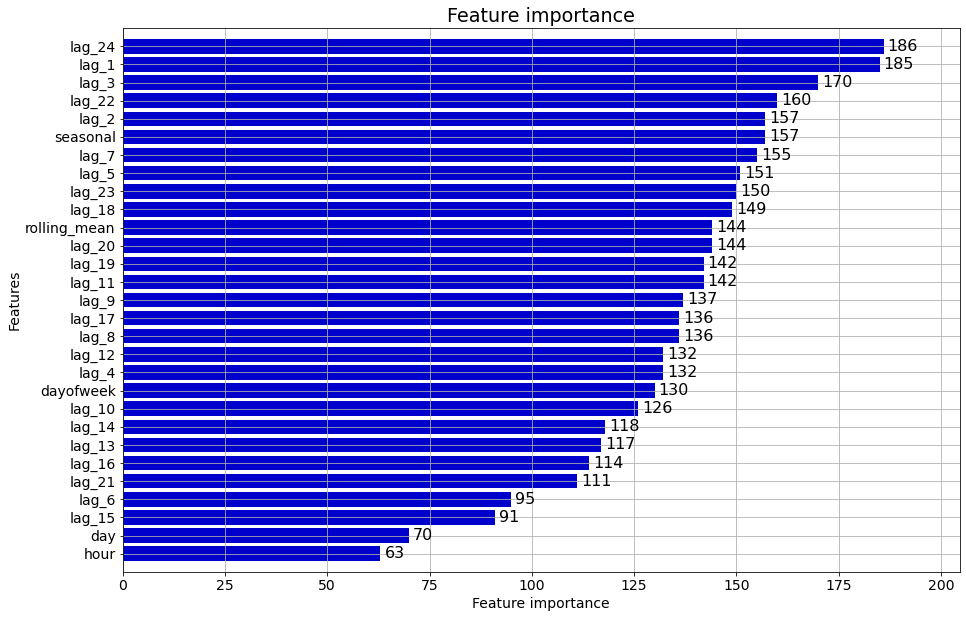

In [225]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['font.size'] = '16'
lgb.plot_importance(lgbm, ax=ax, height=0.8, xlim=None, 
                         ylim=None, title='Feature importance', xlabel='Feature importance', 
                         ylabel='Features', importance_type='auto', max_num_features=None, ignore_zero=True, 
                         dpi=100, grid=True, color='mediumblue')
plt.show()

**Вывод**
***  
Модель с лучшими гиперпараметрами LGBMRegressor(n_estimators=130, random_state=5).  
RMSE на тренировочной выборке - 23.5.  
Наиболее важные признаки для модели LGBMRegressor - lag24, lag1, lag3.

#### RandomForestRegressor

In [226]:
params_forest  = {'n_estimators': [i for i in range(50, 160, 20)],
                  'max_depth': [2, 4, 6],
                  'min_samples_split': [2, 3, 5],
                 'bootstrap': [True, False],
                  'n_jobs': [-1],
                  'min_samples_leaf': [1, 2, 4],
                  'ccp_alpha': [0, 0.9]
                 }


In [227]:
%%time
forest, rmse_forest = rndm_search(RandomForestRegressor(random_state=5), params_forest)

Количество итераций:  10
Модель с лучшими гиперпараметрами RandomForestRegressor(ccp_alpha=0, max_depth=6, min_samples_leaf=2,
                      n_estimators=110, n_jobs=-1, random_state=5)
RMSE 23.88
Wall time: 23.6 s


In [228]:
pred_forest_train = forest.predict(features_train)
pred_forest_train

array([ 89.50225337,  77.57654655,  60.47425431, ..., 112.63495421,
        94.73424982,  87.75541981])

In [229]:
append_train_result('RandomForestRegressor', forest, rmse_forest, pred_forest_train)

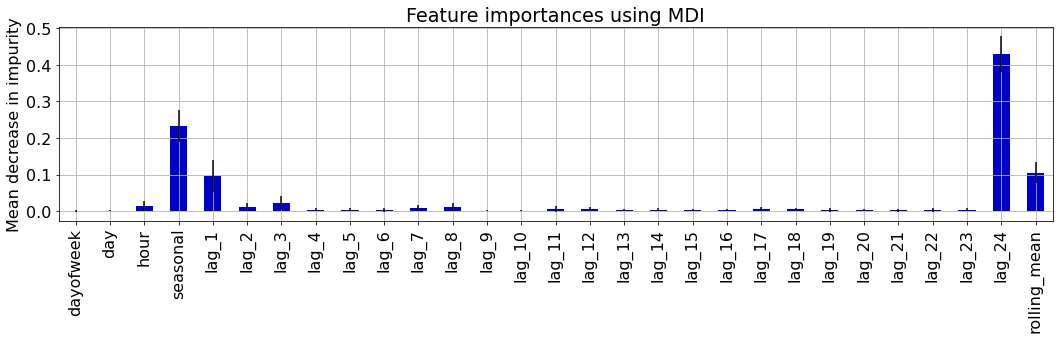

In [230]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features_train.columns)

fig, ax = plt.subplots(figsize=(15, 5))
forest_importances.plot.bar(yerr=std, ax=ax, color='mediumblue', grid=True)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Вывод**
***  
Лучшей оказалась модель с гиперпараметрами: 
- RandomForestRegressor(ccp_alpha=0, max_depth=6, min_samples_leaf=2, n_estimators=110, n_jobs=-1, random_state=5).
- RMSE модели на тренировочной выборке 23.9. 
- Наиболее важные признаки - seasonal, lag24, seasonal, rolling_mean.

####  LinearSVR

In [231]:
params_svr = {'C': [.1, .5, .8, 1],
              'tol': [0.1, 0.001, 0.0001],
              'intercept_scaling': [1, 4, 5], 
              'epsilon': [0, 1, 2]}

In [232]:
%%time
svr, rmse_svr = rndm_search(LinearSVR(random_state=5), params_svr)

Количество итераций:  10
Модель с лучшими гиперпараметрами LinearSVR(C=0.1, epsilon=2, intercept_scaling=1, random_state=5)
RMSE 24.73
Wall time: 5.91 s


C:\Users\Olli\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [233]:
pred_svr_train = svr.predict(features_train)
pred_svr_train

array([ 70.16073698,  82.25160882,  64.09936723, ...,  91.33299831,
       118.41489244, 116.89578769])

In [234]:
append_train_result('LinearSVR', svr, rmse_svr, pred_svr_train)

**Вывод**
***
Модель с лучшими гиперпараметрами LinearSVR(C=0.1, epsilon=2, intercept_scaling=1, random_state=5)
RMSE LinearSVR 24.7 

#### Lasso

In [235]:
params_Lasso  = {'alpha': np.arange(.1, 1.1, .1), 
                 'precompute': [True, False], 
                 'copy_X': [True, False], 
                 'max_iter': [i for i in range(500, 2500, 100)], 
                 'selection': ['cyclic', 'random']
                    }

In [236]:
%%time
lasso, rmse_lasso = rndm_search(linear_model.Lasso(), params_Lasso)

Количество итераций:  10
Модель с лучшими гиперпараметрами Lasso(alpha=0.9, copy_X=False, max_iter=2100, precompute=True)
RMSE 24.19
Wall time: 649 ms


In [237]:
pred_lasso_train = lasso.predict(features_train)
pred_lasso_train

array([ 79.11062874,  90.09184274,  77.64863113, ..., 120.66148954,
       128.97802477, 137.61442806])

In [238]:
append_train_result('Lasso', lasso, rmse_lasso, pred_lasso_train)

**Вывод**
***
Модель с лучшими гиперпараметрами Lasso(alpha=0.9, copy_X=False, max_iter=2100, precompute=True) 
RMSE модели  24.2

#### ElasticNet

In [239]:
params_MEN = {'alpha': np.arange(.1, 1.1, .1),
              'l1_ratio': [0, 0.5, 1], 
              'normalize': [True, False], 
              'precompute': [True, False], 
              'copy_X': [True, False], 
              'selection': ['cyclic', 'random']
             }

In [240]:
%%time
ElasticNet, rmse_EN = rndm_search(linear_model.ElasticNet(random_state=5), params_MEN)

Количество итераций:  10
Модель с лучшими гиперпараметрами ElasticNet(alpha=0.8, l1_ratio=1, precompute=True, random_state=5,
           selection='random')
RMSE 24.20
Wall time: 469 ms


C:\Users\Olli\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2950.7418824343476, tolerance: 591.0512749050392
  model = cd_fast.enet_coordinate_descent_gram(


In [241]:
pred_EN_train = ElasticNet.predict(features_train)

In [242]:
append_train_result('ElasticNet', ElasticNet, rmse_EN, pred_EN_train)

**Вывод**
***
Модель с лучшими гиперпараметрами ElasticNet(alpha=0.8, l1_ratio=1, precompute=True, random_state=5, selection='random').    
RMSE модели  24.2

### Результаты работы обученных моделей на тренировочной выборке

Оценим предсказание каждой модели на тренировочных данных, обученные с помощью кросс-валидации для временных рядов.   
Проверим, на сколько каждая модель приблизилась к реальному целевому признакку на тренировочных данных.

In [243]:
pd.DataFrame({'rmse_train': rmse_train}, index=model_name)

,rmse_train
LinearRegression,23.976437
LGBMRegressor,23.490974
RandomForestRegressor,23.876937
LinearSVR,24.730603
Lasso,24.194100
ElasticNet,24.196520


Лучшую метрику RMSE на тренировочной выборке показала модель LGBMRegressor 23.5, худшую - LinearSVR - 24.7.  
Остальные модели показали примерно одинаковую метрику в пределах от 23.5 до 24.2.  

Построим графики плотности распределения истиного значения целевого признака на тренировочной выборке и предсказанного, а так же, линейный график по времени. 

In [244]:
for i in range(len(model_name)):   
    new_col(predict_train, pred_train[i], name=model_name[i], rolling_size=50)

In [245]:
predict_train.tail(5)

,real_target,LinearRegression,LGBMRegressor,RandomForestRegressor,LinearSVR,Lasso,ElasticNet
datetime,,,,,,,
2018-08-13 09:00:00,119.50,114.883264,116.087544,110.429621,104.367410,114.367748,114.351038
2018-08-13 10:00:00,120.50,115.621525,117.199963,111.194870,104.810659,115.073190,115.059649
2018-08-13 11:00:00,120.98,115.610687,117.528290,111.050348,104.225116,114.985362,114.971424
2018-08-13 12:00:00,120.02,115.400191,116.878478,110.435191,104.127500,114.827030,114.812017
2018-08-13 13:00:00,120.78,115.315773,117.447205,110.078512,104.042601,114.830713,114.816437


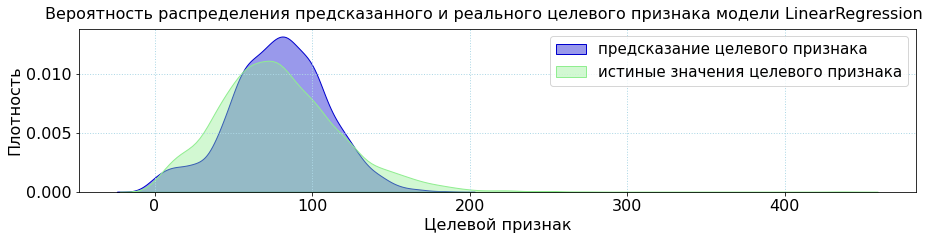

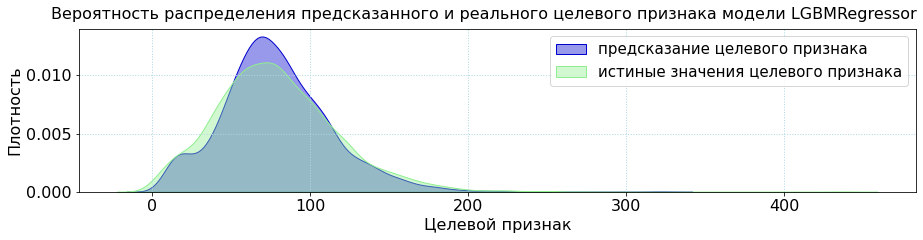

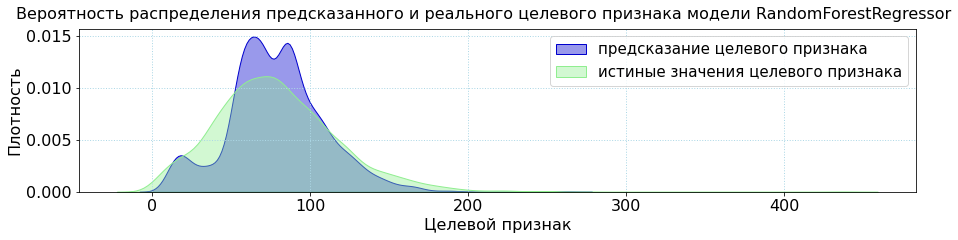

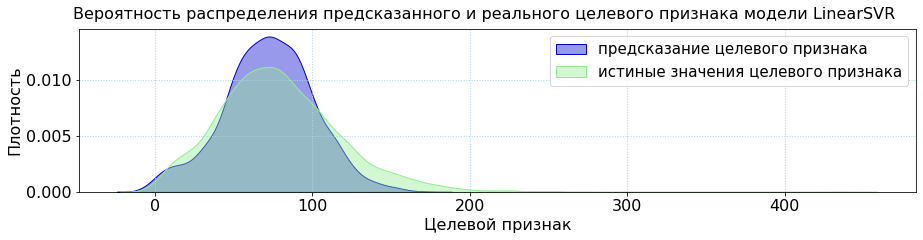

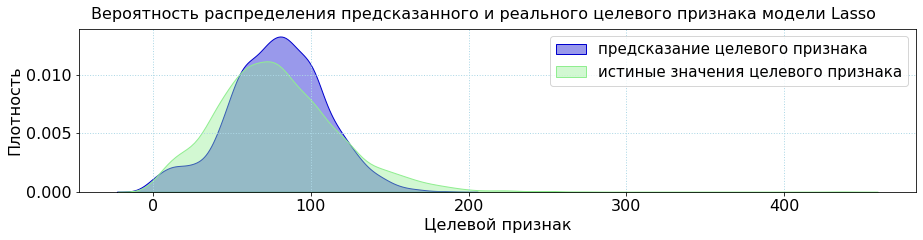

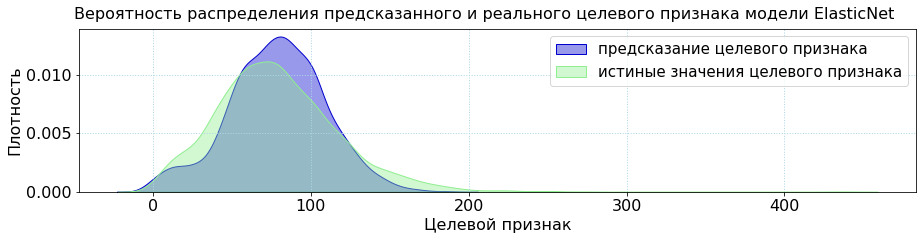

In [246]:
for i in range(len(model_name)): 
    
    predictions_kdeplot(pred_train[i], target_train, 
                       suptitle_1=(
                           'Вероятность распределения предсказанного и реального целевого признака модели ' + model_name[i]),
                       figsize_1=(15, 3)
                       )

    plt.show()

Несмотря на то, что модель случайного леса показала не самую худшую RMSE на тренировочных данных, распределение предсказанного признака сильно отличается от реального - имеются два пика, в отличие от реальных значений с одним пиком, а так же хвосты распределний находятся далеко от реальных. 

Ближе всего по плотности распределения оказались модели LGBMRegressor - с результатом точности RMSE в 23.4.

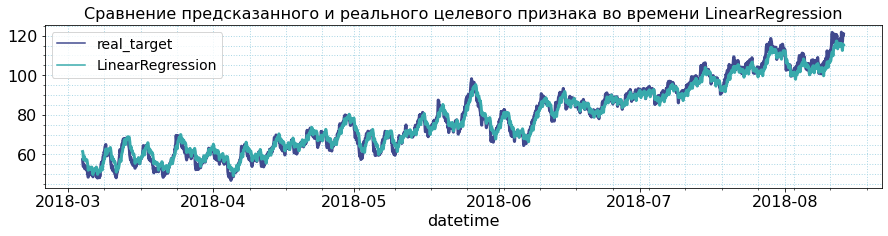

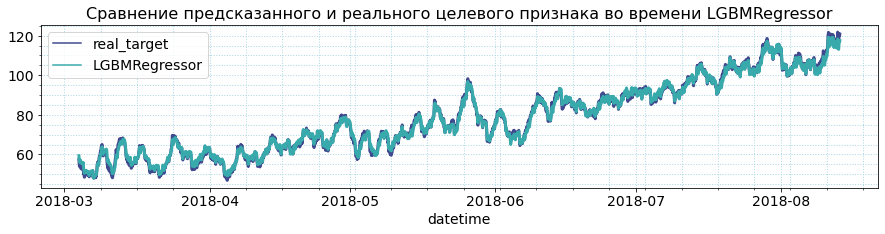

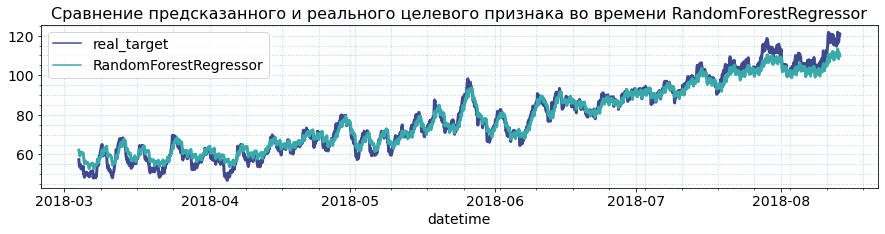

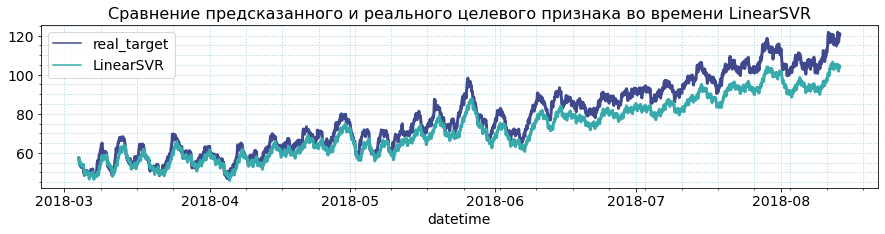

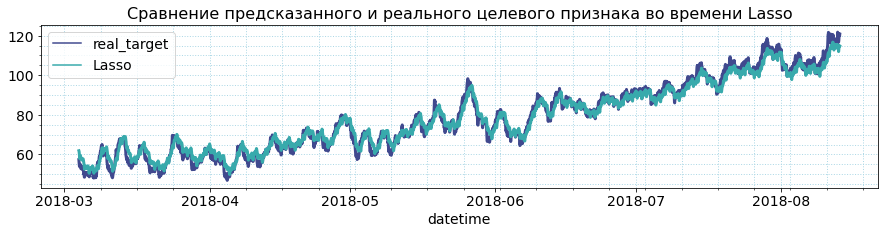

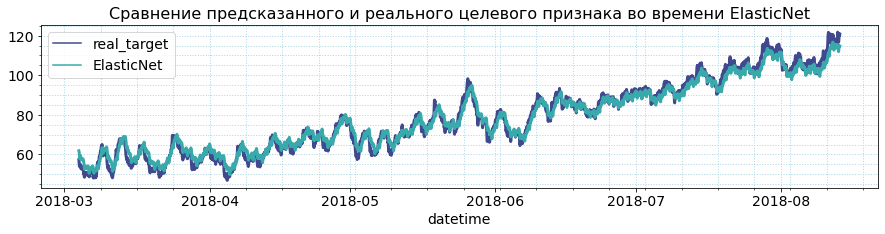

In [247]:
for i in range(len(model_name)):     
    oneplot(df=predict_train[['real_target', model_name[i]]], 
            title1=('Сравнение предсказанного и реального целевого признака во времени ' + model_name[i]), 
            height=3, width=15)


**Вывод**
***  
Лучшую точность показали модели LGBMRegressor, с течением времени качество предсказания на тренировочной выборке не меняется. 
Ближе всего по плотности распределения оказались модели LGBMRegressor - с результатом точности RMSE в 23.4.  
Проверим работу на тестовой выборке.

## Тестирование

In [248]:
def rmse_result(model, features=features_test, target=target_test):
    
    predictions = model.predict(features)
    
    rmse = mean_squared_error(predictions, target)**0.5
    
    print(f'RMSE модели: {rmse:.2f}'.format())
       
    return predictions, rmse

In [249]:
predict_test = pd.DataFrame(index=features_test.index)
predict_test['real_target'] = target_test

Перед тестированием проверим результат работы Дамми модели.

In [250]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

print('Точность предсказания Дамми модели на тестовой выборке')
pred_dummy, RMSE_dummy = rmse_result(dummy_regr, features=features_test, target=target_test)

Точность предсказания Дамми модели на тестовой выборке
RMSE модели: 84.65


In [251]:
for i in range(len(model_name)):
    
    print('Результат предсказания', model_name[i], 'на тестовой выборке')
    
    pred_test_result, rmse_test_result = rmse_result(best_model[i])
    
    pred_test.append(pred_test_result)
    rmse_test.append(rmse_test_result)
    print()    

Результат предсказания LinearRegression на тестовой выборке
RMSE модели: 42.18

Результат предсказания LGBMRegressor на тестовой выборке
RMSE модели: 39.97

Результат предсказания RandomForestRegressor на тестовой выборке
RMSE модели: 45.23

Результат предсказания LinearSVR на тестовой выборке
RMSE модели: 47.84

Результат предсказания Lasso на тестовой выборке
RMSE модели: 42.22

Результат предсказания ElasticNet на тестовой выборке
RMSE модели: 42.22



In [252]:
for i in range(len(model_name)):   

     predict_test[model_name[i]] = pred_test[i]

In [253]:
pd.DataFrame({'rmse_train': rmse_train, 'rmse_test': rmse_test}, index=model_name)

,rmse_train,rmse_test
LinearRegression,23.976437,42.177179
LGBMRegressor,23.490974,39.967867
RandomForestRegressor,23.876937,45.225060
LinearSVR,24.730603,47.844918
Lasso,24.194100,42.216031
ElasticNet,24.196520,42.219710


На тестовой выборке LGBMRegressoro показали самую высокую точность предсказаний, RMSE моделей около 40.

Худшую точность показала модель LinearSVR - точность предсказаний до ~48.  

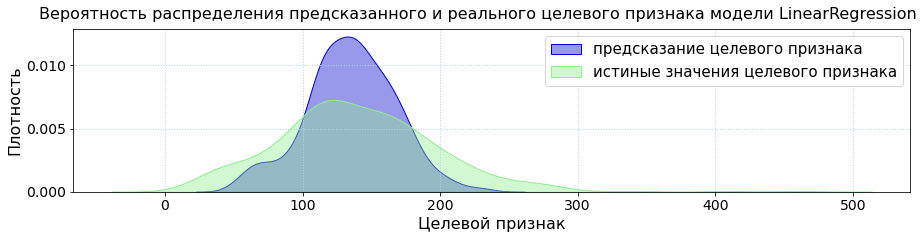

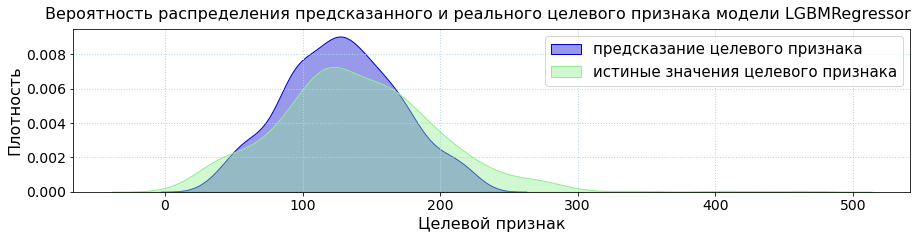

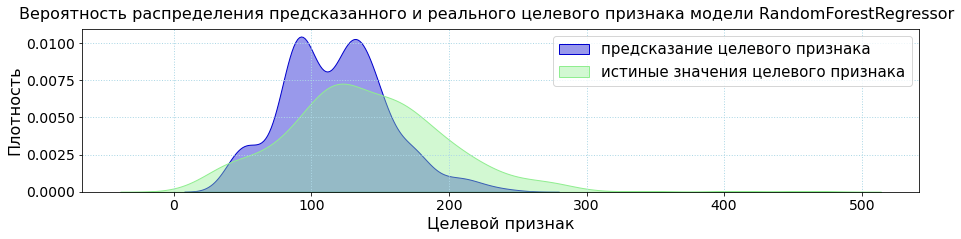

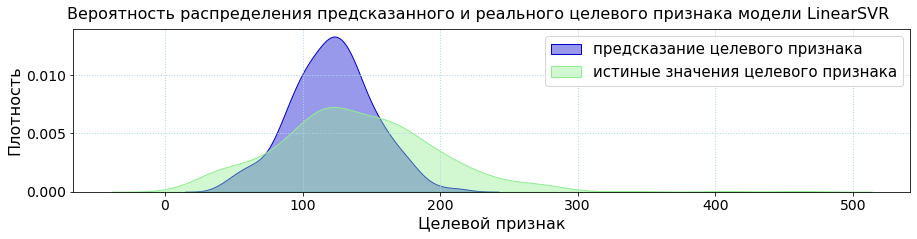

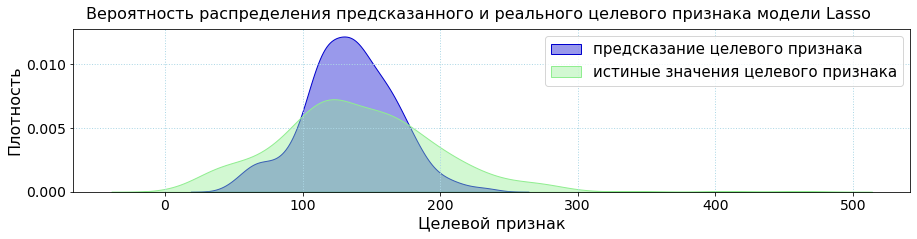

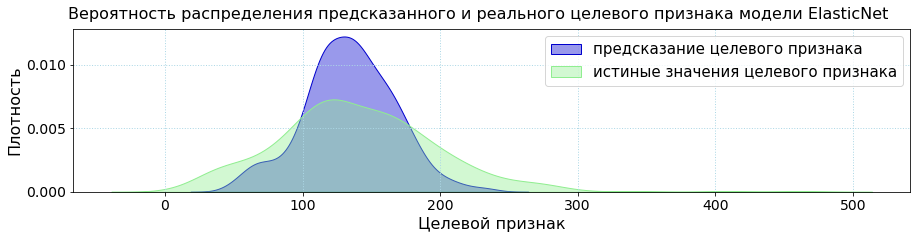

In [254]:
for i in range(len(model_name)): 
    
    predictions_kdeplot(pred_test[i], target_test, 
                       suptitle_1=(
                           'Вероятность распределения предсказанного и реального целевого признака модели ' + model_name[i]),
                       figsize_1=(15, 3)
                       )

    plt.show()

Предсказания моделей RandomForestRegressor, LinearSVR смещены вправо - пик распределения предсказаний не совпадает с истиным пиком, у модели RandomForestRegressor наблюдается два пика вместо одного.

Расрпеделение предсказаний модели LGBMRegressoro близко к истинному, отличие в высоте пика и хвостах распределния.

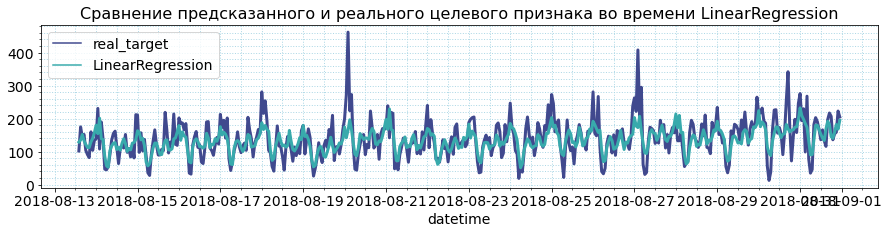

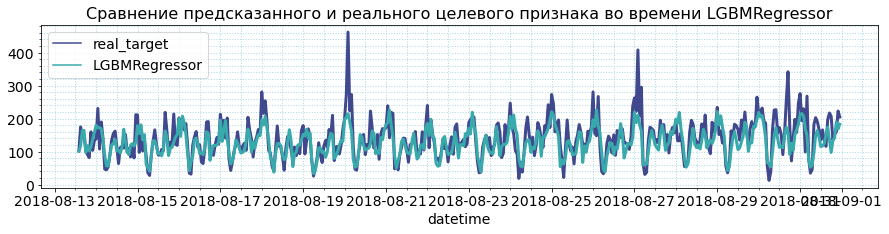

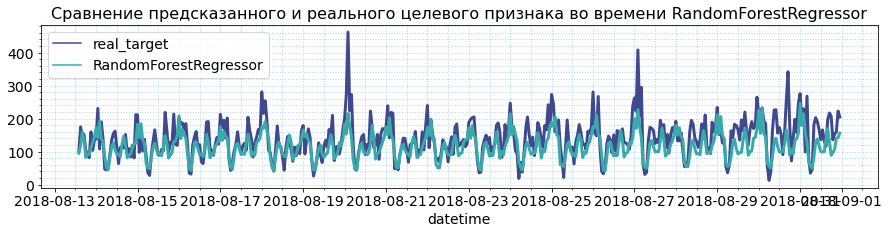

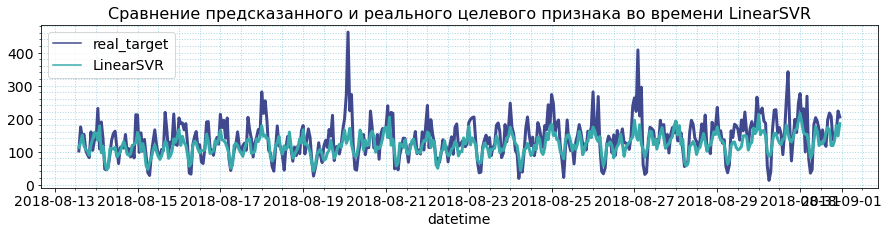

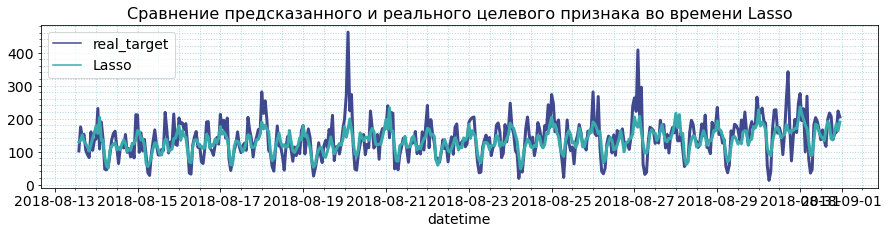

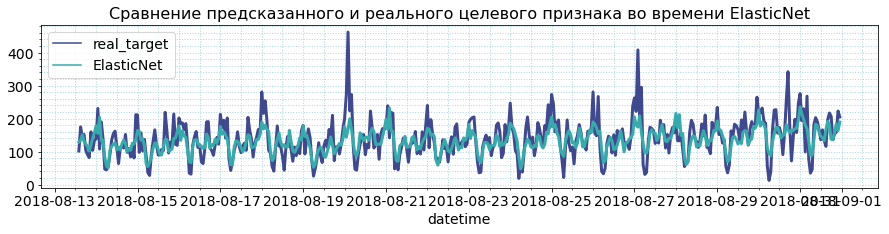

In [255]:
for i in range(len(model_name)):     
    oneplot(df=predict_test[['real_target', model_name[i]]], 
            title1=('Сравнение предсказанного и реального целевого признака во времени ' + model_name[i]), 
            height=3, width=15)

**Вывод**
***  

Лучшую точность предсказания показала модель LGBMRegressoror с метрикой RMSE около 40. Распределение предсказания модели близки к реальным, а так же, предсказания повторяют тренд истинных значений признака.  
Худшую точность показала модель LinearSVR с RMSE около 48.  
RMSE остальных обученных моделей в диапазоне от 42 до 45.  
RMSE Дамми модели равна 84, все модели показали точность более высокую, чем Дамми модель. 

## Вывод

Целью исследования было получить модель, которая предсказвает пиковые значения заказов такси.   

Исходные данные представляют собой временной ряд с количеством заказов с периодичностью в 10 минут. Для обучения модели ряд был ресемплирован с периодичностью в 1 час. Данные предсавлены за период с марта 2018 года по август 2018 включительно.   

Во временном ряду наблюдается суточная сезонность заказов - с максимальным количеством заказов в полночь и минимальным ранним утром - около 6:00. Так же, в исходном ряду наблюдается восходящий тренд к августу.   

В целях обучения моделей были построены новые признаки, а именно:  
- день ['day']
- день недели ['dayofweek']
- час ['hour']
- смещенный ряд со скользящим средним ['rolling_mean'] и 24 смещенных ряда ['lag_n'].

Подготовленные данные были разделены на обучающую и тестовоую выборки, тестовая выборка составила 10% от исходного датасета.

С помощью кросс-валидации для временных рядов были обучены следующие модели:

- LinearRegression  
- LGBMRegressor  
- RandomForestRegressor
- LinearSVR  
- Lasso  
- ElasticNet

Подбор гиперпараметров производился с помощью RandomizedSearchCV.

Путем тестирования лучшую точность предсказаний показала модель:

- LGBMRegressor(n_estimators=130, random_state=5) на тестовой выборке RMSE составила 40.

Остальные исследованные модели показали худшее значение точности предсказания от 42 до 47. 

Точночть Дамми модели составила 84, что показывает, что все модели, даже самые не точные показали лучшую точность предсказания, чем Дамми модель.